# Table of Contents
1 - [Problem Statement](#ps)  
2 - [Overview of Dataset](#dataset)  
3 - [Loading the Data](#load)   
4 - [Exploratory Data Analysis](#eda)   
&emsp;  4.1 - [Data Cleaning: Deduplication](#deduplication)   
5 - [Text Preprocessing Using NLTK](#textprep)  
6 - [Train and Test Split of Data](#split)  
7 - [Naive Bayes Classification Model](#nb)  
&emsp;  7.1 - [Function to find the optimal alpha and error using 10-fold cross-validation](#bestalpha)  
&emsp;  7.2 - [Function to find the features importance and prediction on TestData](#acc)  
8 - [Featurization Methods](#vec)  
&emsp;  8.1 - [Bag Of Words(unigram)](#bowuni)   
&emsp;  8.2 - [Bag Of Words(bigram)](#bowbi)  
&emsp;  8.3 - [TF-IDF(unigram)](#tfidfuni)  
&emsp;  8.4 - [TF-IDF(bigram)](#tfidfbi)      
9 - [Conclusion](#conclusion)

## [1] Problem Statement : <a name="ps"></a>

-  Time Based slicing to split Train Data(70%) and Test Data(30%).
-  Appling Naive Bayes model to find the optimal alpha and using 10 fold Cross Validation in :  
&emsp; 1)Bag Of Words  
&emsp; 2)TF-IDF  
-  Finding the features Importance for each class label.  
-  Plotting Confusion Matrix.  
-  Using Precission, Recall, F1 Score as performance metrics and comparing between various featurization techniques.

## [2] Overview of Dataset : <a name="dataset"></a>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.  

Number of reviews: 568,454  
Number of users: 256,059  
Number of products: 74,258  
Timespan: Oct 1999 - Oct 2012  
Number of Attributes/Columns in data: 10  

Attribute Information:

&emsp;1.Id  
&emsp;2.ProductId - unique identifier for the product  
&emsp;3.UserId - unqiue identifier for the user  
&emsp;4.ProfileName  
&emsp;5.HelpfulnessNumerator - number of users who found the review helpful  
&emsp;6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not  
&emsp;7.Score - rating between 1 and 5  
&emsp;8.Time - timestamp for the review  
&emsp;9.Summary - brief summary of the review  
&emsp;10.Text - text of the review  

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## [3] Loading the Data : <a name="load"></a>

In order to load the data, we have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#Importing the necessary Packages
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import time
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML
from collections import OrderedDict


from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [2]:
import pickle

#dumping an object to file object using dump method
def dumpfile(a,file_Name):
    fileObject = open(file_Name,"wb")
    pickle.dump(a,fileObject,protocol=2)
    fileObject.close()

#loading an object from file object using load method
def loadfile(file_Name):
    fileObject = open(file_Name,"rb")
    b = pickle.load(fileObject)
    return b


In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 2px  black solid !important;
}
</style>

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [5]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [6]:
print("Number of datapoints: ",filtered_data.shape[0])
print("Number of attributes/features: ",filtered_data.shape[1])
HTML(filtered_data.head().to_html(index=False))

Number of datapoints:  525814
Number of attributes/features:  10


Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## [4] Exploratory Data Analysis :<a name="eda"></a>

### [4.1] Data Cleaning: Deduplication <a name="deduplication"></a>
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

<b>Deduplication 1:-</b> As can be seen below the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Deduplication 2:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


<b>Deduplication 3:-</b> It was also seen that a same user has given different reviews for a same product at same time.I think it is normal for a user to give multiple reviews about a product,but that should be in diffrent time.<br>
So,all those rows with same user giving multiple reviews for a same product at same time are considered as duplicate and hence dropped.

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId= "A8891HVRDJAM6" 
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
86221,B000084E6V,A8891HVRDJAM6,"Marfaux ""Marfaux""",33,33,5,1161388800,Dog LOVE these!,We purchase these dinosaurs constantly. For s...
86236,B000084E6V,A8891HVRDJAM6,"Marfaux ""Marfaux""",3,3,5,1161388800,Very entertaining!,These dinos are great for powerful chewers! Ou...


In [13]:
final=final.drop_duplicates(subset={"ProductId","UserId","ProfileName","Time"}, keep='first', inplace=False)
print(final.shape)

(363633, 10)


<b>Deduplication 4:-</b> It was also seen that in few rows with Ids from 150493 to 150529 contain reviews regarding books,not fine foods.So I think these should be also removed from the dataset.
After looking at the productid column, it can be noticed that all the observations for fine foods start with B followed by numbers except for Ids from 150493 to 150529. 
I suppose the reviews for book ‘Chicken soup for the soul’ have gotten into the datset mistakenly as they contain the words “chicken soup.

In [14]:
display = final[final.ProductId == "0006641040"]
HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [15]:
final = final[final.ProductId != "0006641040"]

In [16]:
print("Percentage  of data still remaining : ",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

#Before starting the next phase of preprocessing lets see the number of entries left
print("Number of reviews left after Data Cleaning and Deduplication :")
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

Percentage  of data still remaining :  69.14973735959865
Number of reviews left after Data Cleaning and Deduplication :
(363599, 10)


positive    306566
negative     57033
Name: Score, dtype: int64

<b>Observation:-</b>  
It is an imbalanced dataset as the number of positive reviews are way high in number than negative reviews.

## [5] Text Preprocessing Using NLTK : <a name="textprep"></a>

In the Preprocessing phase we do the following in the order below:-

1. Removal of HTML Tags
2. Removal of  any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Removal of  Stopwords
7. Finally Snowball Stemming the word <br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

10
I wanted a treat that was accepted and well liked for my rescue animals.<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains or silly vegetables which virtually all treats contain. Dogs, cats and ferrets are carnivores they are not cattle to eat grain or rabbits to eat vegetables, and WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods? It is dangerous and can cause the death of an animal with diabetes.<br />It is pretty easy to break into smaller pieces for cats and kittens with weak jaws and its wonderful to use as an aid to gain the trust of an abused dog as it will not cause stomach upset when given in common sense amounts.<br />I like that it goes a long way as it costs alot to heal and maintain and train abused and rescued dogs.<br />NO minus to this product other then the price,I can not afford to use it as much as I would like.


### [5.1] Removal of html Tags :

In [21]:
#function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

cleanhtml("<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains")

' This is the only treat that is healthy and loved by all 4 legged beings in my home! It does not contain sugar or grains'

### [5.2] Removal of Punctuations and unecessary characters :

In [22]:
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#|@|~|%|*]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

cleanpunc("WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods?")

'WHYYYY do companies add sugar beet pulp or corn syrup to carnivore foods'

### [5.3] StopWords :

In [23]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
  
stop = set(stopwords.words('english')) #set of stopwords
print(stop)
print("*********************************************************************")
print("No. of stop words: ",len(stop))

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'further', 'should', 'didn', 'them', 'me', "hasn't", 'as', 'ma', 'itself', 'then', 'whom', "weren't", 'has', 'from', 're', 'while', "don't", 'aren', "haven't", 'but', 'such', 'very', "didn't", 'nor', 'so', 'being', "shan't", 'most', 'only', 'hadn', 'ourselves', 'because', 'what', 'were', "isn't", 'the', 'shouldn', "should've", 'own', "wouldn't", 'down', 'couldn', 'can', 'during', 'mightn', 'against', "wasn't", 'up', "hadn't", 'for', 'other', 'hasn', 'myself', 'how', 'theirs', 'did', 'at', 'or', 'do', 't', 'just', 'which', "mightn't", "that'll", 'if', 'we', 'this', 'after', 'now', "mustn't", "it's", 'they', 'than', 'hers', 'his', 'through', 'weren', 'ain', 'their', 'out', 'shan', 'won', 'all', 'had', 'are', 'those', 'above', "you've", 'ours', 'be

In [24]:
exceptions = ["aren't","mightn","wasn","hadn","don't","against","hadn't","shan","weren't","didn","don","hasn't", \
              "hasn","shouldn","didn't","wouldn","wasn't","needn't","shouldn't","wouldn't","aren","isn't","doesn't", \
              "nor","not","needn","couldn't","mightn't","mustn","mustn't","ain","shan't","haven","won't","couldn","isn", \
              "weren","haven't","no","haven't"]
new_stop = []
for i in stop:
    if i not in exceptions:
        new_stop.append(i)


print("No. of stop words after removing exceptions: ",len(new_stop))

No. of stop words after removing exceptions:  140


### [5.4] Stemming :

In [25]:
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

print("Orginal word: beautiful" + "|" +  "Stem word: " + sno.stem('beautiful'))
print("Orginal word: beauty" + "|" +  "Stem word: " + sno.stem('beauty'))
print("Orginal word: loved" + "|" +  "Stem word: " + sno.stem('loved'))
print("Orginal word: loving" + "|" +  "Stem word: " + sno.stem('loving'))

Orginal word: beautiful|Stem word: beauti
Orginal word: beauty|Stem word: beauti
Orginal word: loved|Stem word: love
Orginal word: loving|Stem word: love


<b>Observation:-</b>  
We can see words like "beautiful" and "beauty" have their stem as "beauti","loved" and "loving" have their stem as "love".  
Hence it helps in reducing the dimensions by taking the root stem of words.

### [5.5] Implementing the preprocessing steps one by one on all the<br>reviews of dataset :

In [22]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in new_stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [23]:
from nltk.probability import FreqDist
pdist = FreqDist(all_positive_words)
top_positive = pdist.most_common(20)
print("Top 20 Positive words ocuring frequenty in reviews:")
top_positive

Top 20 Positive words ocuring frequenty in reviews:


[(b'not', 146568),
 (b'like', 139160),
 (b'tast', 128865),
 (b'good', 112601),
 (b'flavor', 109329),
 (b'love', 107172),
 (b'use', 103792),
 (b'great', 103670),
 (b'one', 96529),
 (b'product', 90912),
 (b'tri', 86683),
 (b'tea', 83699),
 (b'coffe', 78763),
 (b'make', 75004),
 (b'get', 71996),
 (b'food', 64539),
 (b'would', 55477),
 (b'time', 55184),
 (b'buy', 54137),
 (b'realli', 52657)]

In [24]:
ndist = FreqDist(all_negative_words)
top_negative = ndist.most_common(20)
print("Top 20 Negative words ocuring frequenty in reviews:")
top_negative

Top 20 Negative words ocuring frequenty in reviews:


[(b'not', 54325),
 (b'tast', 34534),
 (b'like', 32271),
 (b'product', 28181),
 (b'one', 20544),
 (b'flavor', 19520),
 (b'would', 17947),
 (b'tri', 17718),
 (b'use', 15280),
 (b'good', 15024),
 (b'coffe', 14700),
 (b'get', 13775),
 (b'buy', 13742),
 (b'order', 12862),
 (b'food', 12720),
 (b'dont', 11865),
 (b'tea', 11646),
 (b'even', 11068),
 (b'box', 10833),
 (b'amazon', 10067)]

### [5.6] Adding a new column of CleanedText which displays the data after<br>pre-processing of the review  :

In [27]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [26]:
final[['Text','CleanedText']].head(10)

,Text,CleanedText
476617,This product by Arche...,product archer farm b...
22621,Our dogs just love th...,dog love saw pet stor...
22620,My dogs loves this ch...,dog love chicken prod...
284375,This book is easy to ...,book easi read ingred...
157850,I have been feeding m...,feed greyhound treat ...
157849,This is one product t...,one product welsh ter...
157833,This is the ONLY dog ...,dog treat lhasa apso ...
157832,These liver treas are...,liver trea phenomen r...
157837,This was the only tre...,treat dog like obedi ...
157831,"No waste , even if sh...",wast even day goe hun...


### [5.7] Using SQLite Table to load data after preprocessing <br> of reviews  :

In [ ]:
# store final result into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [6]:
# using the SQLite Table to read data.
conn = sqlite3.connect('final.sqlite') 

final = pd.read_sql_query(""" SELECT * FROM Reviews """,conn) 

In [7]:
#Listing out the number of positive and negative reviews
final = final.reset_index(drop=True)
final['Score'].value_counts()

positive    306566
negative     57033
Name: Score, dtype: int64

In [8]:
(final['Score'].value_counts()/len(final['Score']))*100

positive    84.314313
negative    15.685687
Name: Score, dtype: float64

## [6] Train and Test Split of Data : <a name="split"></a>

<b>Sorting the data by Time :</b>

In [10]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
387,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
293,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
386,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
209,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
271,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


<b>Time Based Slicing :</b>  
-  Diving the data to Train set(first 70% ie older data) and Test  Set(last 30% ie recent data)

In [11]:
from sklearn.model_selection import train_test_split

X = final["CleanedText"].values
y = final["Score"].values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False)

In [5]:
print("Shape of X_train: ",X_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of X_train:  (254519,)
Shape of y_train:  (254519,)
Shape of X_test:  (109080,)
Shape of y_test:  (109080,)


In [13]:
dumpfile(X,"X")
dumpfile(y,"y") 
dumpfile(X_train,"X_train")
dumpfile(y_train,"y_train")
dumpfile(X_test,"X_test")
dumpfile(y_test,"y_test")

In [4]:
X = loadfile("X")
y = loadfile("y")
X_train = loadfile("X_train")
y_train = loadfile("y_train")
X_test = loadfile("X_test")
y_test = loadfile("y_test")

## [7] Naive Bayes : <a name="nb"></a>

### [7.1] Function to find the optimal alpha and error using K-fold cross-validation : <a name="bestalpha"></a>
-  Taking alpha between range 0.0001 and 1000.  
-  TimeSeries Split and performing K fold cross validation on Train Data  
-  Finding the optimal alpha  
-  Plotting between CV error/CV Accuracy and Alpha

<b>Bernoulli Naive Bayes :</b> BernoulliNB is suitable for discrete data designed for for binary/boolean features.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score as cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')


alpha_values = [0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha = alpha_values)

def BernoulliNB_Train(X_train,y_train):
    
    model = BernoulliNB()
    grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    grid_mean_scores = [i.mean_validation_score for i in grid.grid_scores_]
    
    #Misclassification error
    MSE = [1 - x for x in grid_mean_scores]
    
    #Finding the optimal K
    optimal_alpha = grid.best_params_
    
    best_accuracy = np.round(grid.best_score_ * 100,3)
    
    print("\n\033[1mOptimal alpha:\033[0m ", optimal_alpha)
    print("\n\033[1mCrossValidation Error:\033[0m {}".format(np.round(min(MSE),3)))
    print("\n\033[1mCrossValidation Accuracy:\033[0m {} %\n\n".format(best_accuracy))
    
    plt.figure(figsize=(20,6))
    plt.style.use('fivethirtyeight')
    plt.subplot(121)
    plt.plot(alpha_values,MSE, 'r-o')
    for xy in zip(alpha_values, np.round(MSE,3)):
        plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV Error vs Alpha Value")
    plt.xlabel("Alpha")
    plt.ylabel("CV Error")
    plt.grid(True)

    plt.subplot(122)
    plt.plot(alpha_values,grid_mean_scores, 'g-o')
    for xy in zip(alpha_values, np.round(grid_mean_scores,3)):
        plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV Accuracy vs Alpha Value")
    plt.xlabel("Alpha")
    plt.ylabel("CV Accuracy")
    plt.grid(True)
    plt.show()
    
    
    print("\n\033[1mCV Error for each value of alpha:\033[0m ",np.round(MSE,3))
    print("\n\033[1mCV Accuracy for each value of alpha:\033[0m ",np.round(grid_mean_scores,3))

<b>Multinomial Naive Bayes :</b>MultinomialNB is suitable for classification with discrete features(count based occurnces).

In [13]:
def MultinomialNB_Train(X_train,y_train):
    
    model = MultinomialNB()
    grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    grid_mean_scores = [i.mean_validation_score for i in grid.grid_scores_]
    
    #Misclassification error
    MSE = [1 - x for x in grid_mean_scores]
    
    #Finding the optimal K
    optimal_alpha = grid.best_params_
    
    best_accuracy = np.round(grid.best_score_ * 100,3)
    
    print("\n\033[1mOptimal alpha:\033[0m ", optimal_alpha)
    print("\n\033[1mCrossValidation Error:\033[0m {}".format(np.round(min(MSE),3)))
    print("\n\033[1mCrossValidation Accuracy:\033[0m {} %\n\n".format(best_accuracy))
    
    plt.figure(figsize=(20,6))
    plt.style.use('fivethirtyeight')
    plt.subplot(121)
    plt.plot(alpha_values,MSE, 'r-o')
    for xy in zip(alpha_values, np.round(MSE,3)):
        plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV Error vs Alpha Value")
    plt.xlabel("Alpha")
    plt.ylabel("CV Error")
    plt.grid(True)

    plt.subplot(122)
    plt.plot(alpha_values,grid_mean_scores, 'g-o')
    for xy in zip(alpha_values, np.round(grid_mean_scores,3)):
        plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV Accuracy vs Alpha Value")
    plt.xlabel("Alpha")
    plt.ylabel("CV Accuracy")
    plt.grid(True)
    plt.show()
    
    
    print("\n\033[1mCV Error for each value of alpha:\033[0m ",np.round(MSE,3))
    print("\n\033[1mCV Accuracy for each value of alpha:\033[0m ",np.round(grid_mean_scores,3))

### [7.2] Function to find the features importance and predict on Test Data : <a name="acc"></a>
-  Finding the features importance for each class 
-  Plotting the Confusion matrix  
-  Finding Acurracy,Precission,Recall and F1 Score on Test Datab


<b>True Negative :</b> Number of datapoints with class label "negative" correctly classified as "negative".   
<b>False Positive :</b> Number of datapoints with class label "negative" misclassified as "positive".  
<b>False Negative :</b> Number of datapoints with class label "positive" misclassified as "negative".  
<b>True Positive:</b> Number of datapoints with class label "positive" correctly classified as "positive".  
<b>Precision :</b> True Positive/(True Positive + False Positive)  
<b>Recall :</b> True Positive/(True Positive + False Negative)

<b>Bernoulli Naive Bayes :</b>

In [14]:
def BernoulliNB_Test(X_train,X_test,y_train,y_test,optimal_alpha,vectorizer,n = 25):

    optimal_model = BernoulliNB(alpha = optimal_alpha)
    optimal_model.fit(X_train, y_train)
    y_pred = optimal_model.predict(X_test)
    
    
    ##--------------Feature Importance-------------------------##
    class_labels = optimal_model.classes_
    feature_names = vectorizer.get_feature_names()
    top_negative = sorted(zip(optimal_model.coef_[0], feature_names))[:n]
    top_positive= sorted(zip(optimal_model.coef_[0], feature_names))[-n:]

    print("\033[1m------------Top {} Negative Words with high Importance------------\033[0m".format(n))
    neg_featureimp_df = pd.DataFrame(top_negative, columns=['Coeficient Factor','Features'])
    print(neg_featureimp_df.to_string(index=False))
    
    
    print("\n\033[1m------------Top {} Positive Words with high Importance------------\033[0m".format(n))
    pos_featureimp_df = pd.DataFrame(top_positive, columns=['Coeficient Factor','Features'],)
    print(pos_featureimp_df.to_string(index=False))
    
    
    
    print("\n\n")

    
    ##--------------Confusion Matrix and Performance metrics
    accuracy = accuracy_score(y_test,y_pred) * 100
    precision = precision_score(y_test,y_pred,average= 'macro')
    recall = recall_score(y_test,y_pred,average= 'macro')
    f1= f1_score(y_test,y_pred,average= 'macro')
    MSE = (1 - (accuracy/100))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm_df = pd.DataFrame(cm,
                     index = ['negative','positive'], 
                     columns = ['negative','positive'])
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(cm)
    print("\n\033[1mTest Error :\033[0m {}".format(np.round(MSE,3)))
    print("\033[1mTest Accuracy :\033[0m {} %".format(np.round(accuracy,3)))
    print("\033[1mTrue Negative :\033[0m {}".format(tn))
    print("\033[1mFalse Positive :\033[0m {}".format(fp))
    print("\033[1mFalse Negative :\033[0m {}".format(fn))
    print("\033[1mTrue Positive :\033[0m {}".format(tp))
    print("\33[1mPrecission Score :\033[0m {}".format(np.round(precision,3)))
    print("\33[1mRecall Score :\033[0m {}".format(np.round(recall,3)))
    print("\33[1mF1 Score :\033[0m {}".format(np.round(f1,3)))

<b>Multinomial Naive Bayes :</b>

In [15]:
def MultinomialNB_Test(X_train,X_test,y_train,y_test,optimal_alpha,vectorizer,n = 25):

    optimal_model = MultinomialNB(alpha = optimal_alpha)
    optimal_model.fit(X_train, y_train)
    y_pred = optimal_model.predict(X_test)
    
    
    ##--------------Feature Importance-------------------------##
    class_labels = optimal_model.classes_
    feature_names = vectorizer.get_feature_names()
    top_negative = sorted(zip(optimal_model.coef_[0], feature_names))[:n]
    top_positive= sorted(zip(optimal_model.coef_[0], feature_names))[-n:]

    print("\033[1m------------Top {} Negative Words with high Importance------------\033[0m".format(n))
    neg_featureimp_df = pd.DataFrame(top_negative, columns=['Coeficient Factor','Features'])
    print(neg_featureimp_df.to_string(index=False))
    
    
    print("\n\033[1m------------Top {} Positive Words with high Importance------------\033[0m".format(n))
    pos_featureimp_df = pd.DataFrame(top_positive, columns=['Coeficient Factor','Features'],)
    print(pos_featureimp_df.to_string(index=False))
    
    
    
    print("\n\n")

    
    ##--------------Confusion Matrix and Performance metrics
    accuracy = accuracy_score(y_test,y_pred) * 100
    precision = precision_score(y_test,y_pred,average= 'macro')
    recall = recall_score(y_test,y_pred,average= 'macro')
    f1= f1_score(y_test,y_pred,average= 'macro')
    MSE = (1 - (accuracy/100))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm_df = pd.DataFrame(cm,
                     index = ['negative','positive'], 
                     columns = ['negative','positive'])
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(cm)
    print("\n\033[1mTest Error :\033[0m {}".format(np.round(MSE,3)))
    print("\033[1mTest Accuracy :\033[0m {} %".format(np.round(accuracy,3)))
    print("\033[1mTrue Negative :\033[0m {}".format(tn))
    print("\033[1mFalse Positive :\033[0m {}".format(fp))
    print("\033[1mFalse Negative :\033[0m {}".format(fn))
    print("\033[1mTrue Positive :\033[0m {}".format(tp))
    print("\33[1mPrecission Score :\033[0m {}".format(np.round(precision,3)))
    print("\33[1mRecall Score :\033[0m {}".format(np.round(recall,3)))
    print("\33[1mF1 Score :\033[0m {}".format(np.round(f1,3)))

## [8] Featurization Methods : <a name="vec"></a>  
<b>Note :</b> Naive Bayes is invariant to feature scaling.

### [8.1] Bag Of Words(unigram) : <a name="bowuni"></a>

<b>Count Based BOW :</b>

In [29]:
%%time
bow_unigram = CountVectorizer()
X_train_bowuni = bow_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_bowuni))
print("The shape of text BOW vectorizer: ", X_train_bowuni.get_shape())
print("Number of unique word: ", X_train_bowuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (254519, 59315)
Number of unique word:  59315
CPU times: user 11.4 s, sys: 92 ms, total: 11.5 s
Wall time: 11.5 s


In [30]:
%%time
X_test_bowuni = bow_unigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_bowuni.get_shape())
print("Number of unique word: ", X_test_bowuni.get_shape()[1])

The shape of text BOW vectorizer:  (109080, 59315)
Number of unique word:  59315
CPU times: user 5.42 s, sys: 8 ms, total: 5.43 s
Wall time: 5.43 s


In [31]:
dumpfile(X_train_bowuni,"X_train_bowuni")
dumpfile(X_test_bowuni,"X_test_bowuni")

In [85]:
X_train_bowuni = loadfile("X_train_bowuni")
X_test_bowuni = loadfile("X_test_bowuni")

In [35]:
print("Shape of Training Data: ",X_train_bowuni.shape)
print("Shape of Test Data: ",X_test_bowuni.shape)

Shape of Training Data:  (254519, 59315)
Shape of Test Data:  (109080, 59315)


<b>Binary BOW :</b>

In [8]:
%%time
binarybow_unigram = CountVectorizer(binary = True)
X_train_binarybowuni = binarybow_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_binarybowuni))
print("The shape of text BOW vectorizer: ", X_train_binarybowuni.get_shape())
print("Number of unique word: ", X_train_binarybowuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (254519, 59315)
Number of unique word:  59315
CPU times: user 11.5 s, sys: 76 ms, total: 11.6 s
Wall time: 11.6 s


In [9]:
%%time
X_test_binarybowuni = binarybow_unigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_binarybowuni.get_shape())
print("Number of unique word: ", X_test_binarybowuni.get_shape()[1])

The shape of text BOW vectorizer:  (109080, 59315)
Number of unique word:  59315
CPU times: user 5.4 s, sys: 12 ms, total: 5.41 s
Wall time: 5.41 s


In [10]:
print("Shape of Training Data: ",X_train_binarybowuni.shape)
print("Shape of Test Data: ",X_test_binarybowuni.shape)

Shape of Training Data:  (254519, 59315)
Shape of Test Data:  (109080, 59315)


### Using Bernoulli Naive Bayes(binary features) :


Optimal alpha:  {'alpha': 0.01}

CrossValidation Error: 0.11

CrossValidation Accuracy: 89.049 %




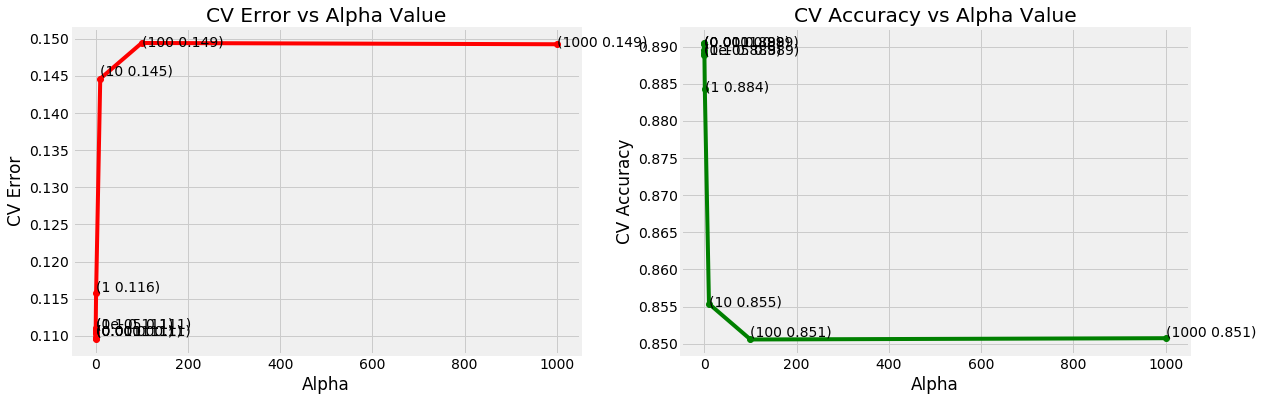


CV Error for each value of alpha:  [0.111 0.11  0.11  0.11  0.111 0.116 0.145 0.149 0.149]

CV Accuracy for each value of alpha:  [0.889 0.89  0.89  0.89  0.889 0.884 0.855 0.851 0.851]
CPU times: user 3min 2s, sys: 2.99 s, total: 3min 5s
Wall time: 3min 4s


In [16]:
%%time
if __name__ == "__main__":
    BernoulliNB_Train(X_train_binarybowuni, y_train)

------------Top 25 Negative Words with high Importance------------
Coeficient Factor            Features
       -16.890669  aaaaaaarrrrrggghhh
       -16.890669  aaaaaahhhhhyaaaaaa
       -16.890669              aachen
       -16.890669              aarrgh
       -16.890669                aauc
       -16.890669              abalon
       -16.890669           abbazabba
       -16.890669               abiet
       -16.890669        abolitionist
       -16.890669               abort
       -16.890669              abottl
       -16.890669              abrevi
       -16.890669           abrotanum
       -16.890669          absolutelt
       -16.890669             absoprt
       -16.890669              absurt
       -16.890669              abswer
       -16.890669             abvious
       -16.890669             accepet
       -16.890669            acceptal
       -16.890669          acceptalbl
       -16.890669               accor
       -16.890669            accordng
       -16.890669    

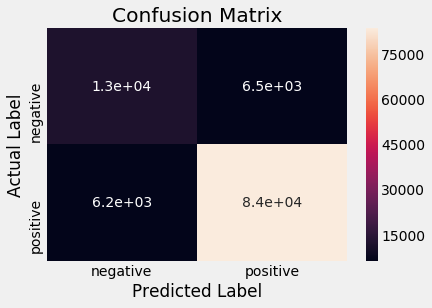

[[12567  6480]
 [ 6226 83807]]

Test Error : 0.116
Test Accuracy : 88.352 %
True Negative : 12567
False Positive : 6480
False Negative : 6226
True Positive : 83807
Precission Score : 0.798
Recall Score : 0.795
F1 Score : 0.797
CPU times: user 8.12 s, sys: 16 ms, total: 8.14 s
Wall time: 7.89 s


In [19]:
%%time
if __name__ == "__main__":
    BernoulliNB_Test(X_train_binarybowuni, X_test_binarybowuni, y_train, y_test, 0.01, binarybow_unigram)

### Using Multinomial Naive Bayes :


Optimal alpha:  {'alpha': 1}

CrossValidation Error: 0.097

CrossValidation Accuracy: 90.299 %




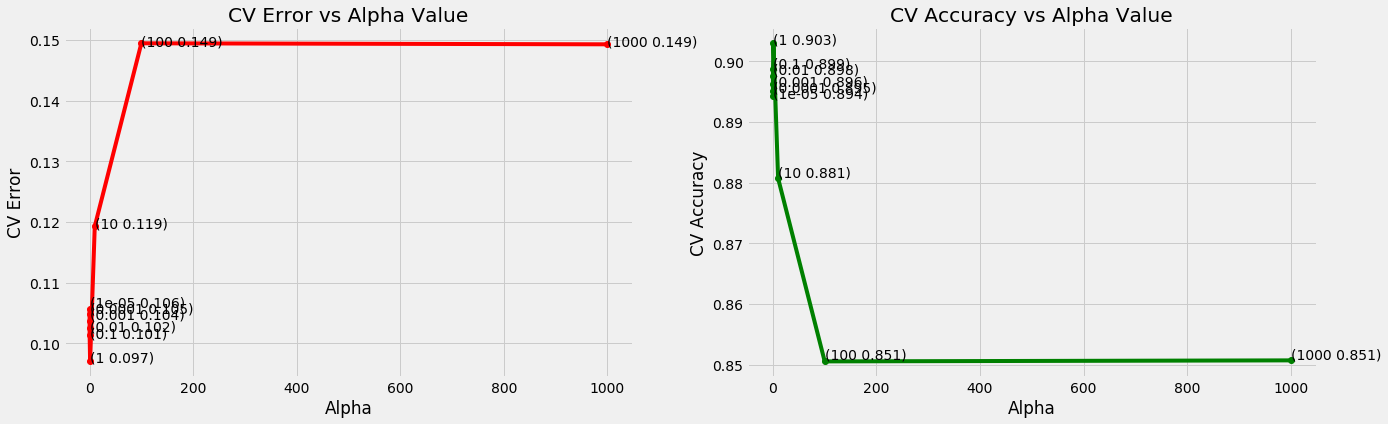


CV Error for each value of alpha:  [0.106 0.105 0.104 0.102 0.101 0.097 0.119 0.149 0.149]

CV Accuracy for each value of alpha:  [0.894 0.895 0.896 0.898 0.899 0.903 0.881 0.851 0.851]
CPU times: user 2min 56s, sys: 1.7 s, total: 2min 57s
Wall time: 2min 57s


In [62]:
%%time
if __name__ == "__main__":
    MultinomialNB_Train(X_train_bowuni, y_train)

------------Top 25 Negative Words with high Importance------------
Coeficient Factor            Features
       -15.931921  aaaaaaarrrrrggghhh
       -15.931921  aaaaaahhhhhyaaaaaa
       -15.931921              aachen
       -15.931921              aarrgh
       -15.931921                aauc
       -15.931921              abalon
       -15.931921           abbazabba
       -15.931921               abiet
       -15.931921        abolitionist
       -15.931921               abort
       -15.931921              abottl
       -15.931921              abrevi
       -15.931921           abrotanum
       -15.931921          absolutelt
       -15.931921             absoprt
       -15.931921              absurt
       -15.931921              abswer
       -15.931921             abvious
       -15.931921             accepet
       -15.931921            acceptal
       -15.931921          acceptalbl
       -15.931921               accor
       -15.931921            accordng
       -15.931921    

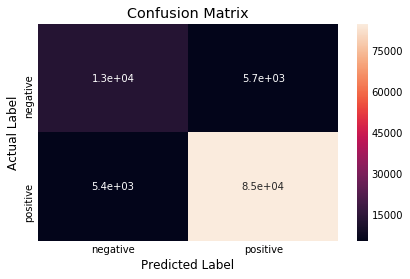

[[13353  5694]
 [ 5404 84629]]

Test Error : 0.102
Test Accuracy : 89.826 %
True Negative : 13353
False Positive : 5694
False Negative : 5404
True Positive : 84629
Precission Score : 0.824
Recall Score : 0.821
F1 Score : 0.822
CPU times: user 7.99 s, sys: 16 ms, total: 8.01 s
Wall time: 7.74 s


In [87]:
%%time
if __name__ == "__main__":
    MultinomialNB_Test(X_train_bowuni, X_test_bowuni, y_train, y_test, 1, bow_unigram)

### [8.2] Bag Of Words(bigram) : <a name="bowbi"></a>

<b>Count Based BOW :</b>

In [36]:
%%time
bow_bigram = CountVectorizer(ngram_range=(1, 2))
X_train_bowbi = bow_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_bowbi))
print("The shape of text BOW vectorizer: ", X_train_bowbi.get_shape())
print("Number of unique word: ", X_train_bowbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (254519, 2295006)
Number of unique word:  2295006
CPU times: user 36.9 s, sys: 320 ms, total: 37.3 s
Wall time: 37.3 s


In [37]:
%%time
X_test_bowbi = bow_bigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_bowbi.get_shape())
print("Number of unique word: ", X_test_bowbi.get_shape()[1])

The shape of text BOW vectorizer:  (109080, 2295006)
Number of unique word:  2295006
CPU times: user 11.9 s, sys: 8 ms, total: 11.9 s
Wall time: 11.9 s


In [38]:
dumpfile(X_train_bowbi,"X_train_bowbi")
dumpfile(X_test_bowbi,"X_test_bowbi")

In [88]:
X_train_bowbi = loadfile("X_train_bowbi")
X_test_bowbi = loadfile("X_test_bowbi")

In [42]:
print("Shape of Training Data: ",X_train_bowbi.shape)
print("Shape of Test Data: ",X_test_bowbi.shape)

Shape of Training Data:  (254519, 2295006)
Shape of Test Data:  (109080, 2295006)


<b>Binary BOW :</b>

In [20]:
%%time
binarybow_bigram = CountVectorizer(ngram_range=(1, 2), binary = True)
X_train_binarybowbi = binarybow_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_binarybowbi))
print("The shape of text BOW vectorizer: ", X_train_binarybowbi.get_shape())
print("Number of unique word: ", X_train_binarybowbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (254519, 2295006)
Number of unique word:  2295006
CPU times: user 37.3 s, sys: 392 ms, total: 37.7 s
Wall time: 37.7 s


In [21]:
%%time
X_test_binarybowbi = binarybow_bigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_binarybowbi.get_shape())
print("Number of unique word: ", X_test_binarybowbi.get_shape()[1])

The shape of text BOW vectorizer:  (109080, 2295006)
Number of unique word:  2295006
CPU times: user 12.1 s, sys: 40 ms, total: 12.2 s
Wall time: 12.2 s


In [22]:
print("Shape of Training Data: ",X_train_binarybowbi.shape)
print("Shape of Test Data: ",X_test_binarybowbi.shape)

Shape of Training Data:  (254519, 2295006)
Shape of Test Data:  (109080, 2295006)


### Using Bernoulli Naive Bayes(binary features) :


Optimal alpha:  {'alpha': 0.001}

CrossValidation Error: 0.094

CrossValidation Accuracy: 90.626 %




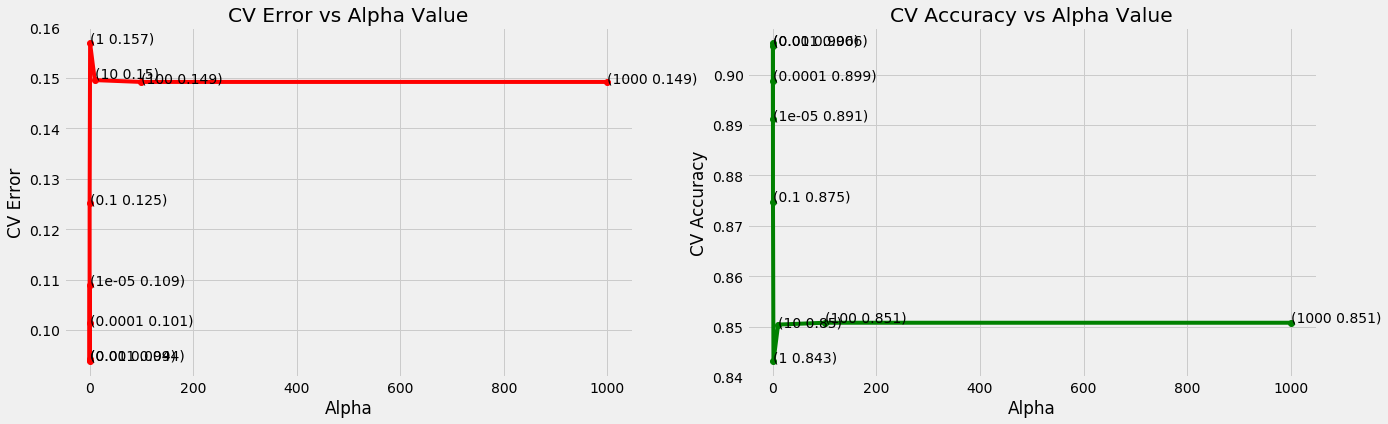


CV Error for each value of alpha:  [0.109 0.101 0.094 0.094 0.125 0.157 0.15  0.149 0.149]

CV Accuracy for each value of alpha:  [0.891 0.899 0.906 0.906 0.875 0.843 0.85  0.851 0.851]
CPU times: user 4min 44s, sys: 10.8 s, total: 4min 55s
Wall time: 4min 55s


In [23]:
%%time
if __name__ == "__main__":
    BernoulliNB_Train(X_train_binarybowbi, y_train)

------------Top 25 Negative Words with high Importance------------
Coeficient Factor                 Features
       -19.193254                 aaa dont
       -19.193254       aaaaaaarrrrrggghhh
       -19.193254  aaaaaaarrrrrggghhh back
       -19.193254       aaaaaahhhhhyaaaaaa
       -19.193254  aaaaaahhhhhyaaaaaa fire
       -19.193254                   aachen
       -19.193254            aachen munich
       -19.193254           aachen printen
       -19.193254            aafco certifi
       -19.193254            aafco definit
       -19.193254              aafco regul
       -19.193254             aamzon howev
       -19.193254                   aarrgh
       -19.193254             aarrgh final
       -19.193254                     aauc
       -19.193254               aauc shelv
       -19.193254             aback flavor
       -19.193254            aback foreign
       -19.193254               aback main
       -19.193254             aback potenc
       -19.193254            a

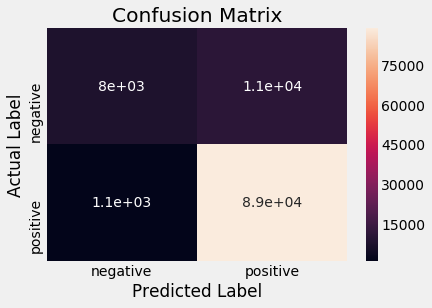

[[ 7957 11090]
 [ 1077 88956]]

Test Error : 0.112
Test Accuracy : 88.846 %
True Negative : 7957
False Positive : 11090
False Negative : 1077
True Positive : 88956
Precission Score : 0.885
Recall Score : 0.703
F1 Score : 0.751
CPU times: user 20.6 s, sys: 128 ms, total: 20.7 s
Wall time: 20.4 s


In [24]:
%%time
if __name__ == "__main__":
    BernoulliNB_Test(X_train_binarybowbi, X_test_binarybowbi, y_train, y_test, 0.001, binarybow_bigram)

### Using Multinomial Naive Bayes :


Optimal alpha:  {'alpha': 1}

CrossValidation Error: 0.093

CrossValidation Accuracy: 90.726 %




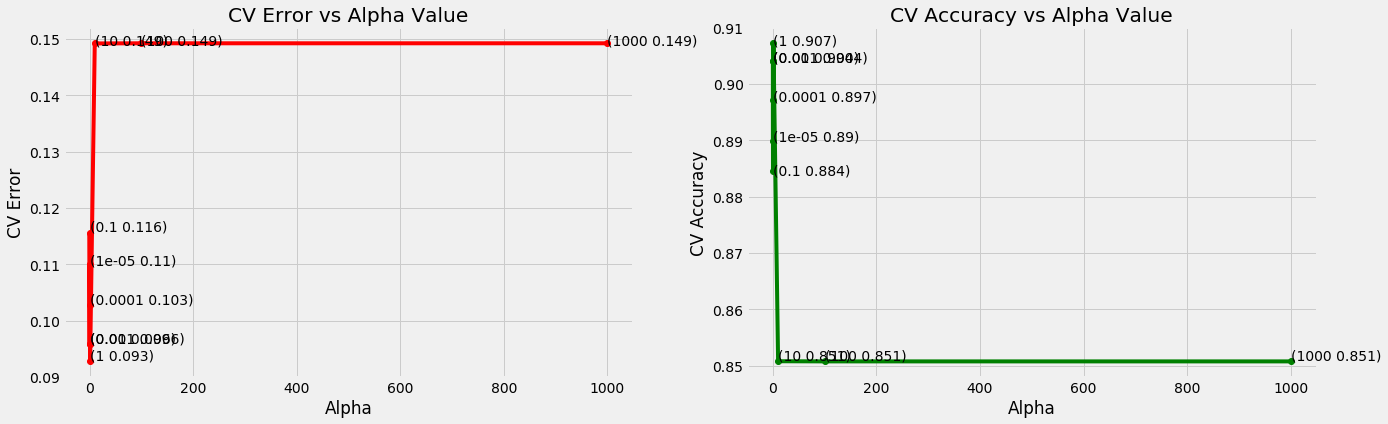


CV Error for each value of alpha:  [0.11  0.103 0.096 0.096 0.116 0.093 0.149 0.149 0.149]

CV Accuracy for each value of alpha:  [0.89  0.897 0.904 0.904 0.884 0.907 0.851 0.851 0.851]
CPU times: user 4min 5s, sys: 7.76 s, total: 4min 13s
Wall time: 4min 13s


In [64]:
%%time
if __name__ == "__main__":
    MultinomialNB_Train(X_train_bowbi, y_train)

------------Top 25 Negative Words with high Importance------------
Coeficient Factor                 Features
        -16.73665                 aaa dont
        -16.73665       aaaaaaarrrrrggghhh
        -16.73665  aaaaaaarrrrrggghhh back
        -16.73665       aaaaaahhhhhyaaaaaa
        -16.73665  aaaaaahhhhhyaaaaaa fire
        -16.73665                   aachen
        -16.73665            aachen munich
        -16.73665           aachen printen
        -16.73665            aafco certifi
        -16.73665            aafco definit
        -16.73665              aafco regul
        -16.73665             aamzon howev
        -16.73665                   aarrgh
        -16.73665             aarrgh final
        -16.73665                     aauc
        -16.73665               aauc shelv
        -16.73665             aback flavor
        -16.73665            aback foreign
        -16.73665               aback main
        -16.73665             aback potenc
        -16.73665            a

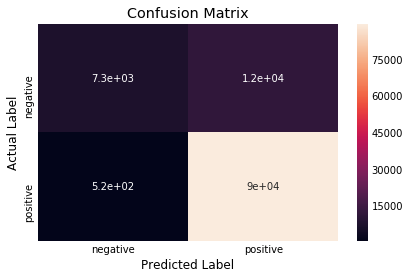

[[ 7344 11703]
 [  515 89518]]

Test Error : 0.112
Test Accuracy : 88.799 %
True Negative : 7344
False Positive : 11703
False Negative : 515
True Positive : 89518
Precission Score : 0.909
Recall Score : 0.69
F1 Score : 0.741
CPU times: user 20.1 s, sys: 44 ms, total: 20.1 s
Wall time: 19.8 s


In [91]:
%%time
if __name__ == "__main__":
    MultinomialNB_Test(X_train_bowbi, X_test_bowbi, y_train, y_test, 1, bow_bigram)

### [8.3] TF-IDF(unigram) : <a name="tfidfuni"></a>

<b>Count Based TF-IDF :</b>

In [43]:
%%time
tfidf_unigram = TfidfVectorizer()
X_train_tfidfuni = tfidf_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_tfidfuni))
print("The shape of text TFIDF vectorizer: ", X_train_tfidfuni.get_shape())
print("Number of unique word: ", X_train_tfidfuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (254519, 59315)
Number of unique word:  59315
CPU times: user 11.6 s, sys: 64 ms, total: 11.6 s
Wall time: 11.7 s


In [44]:
%%time
X_test_tfidfuni = tfidf_unigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_tfidfuni.get_shape())
print("Number of unique word: ", X_test_tfidfuni.get_shape()[1])

The shape of text TFIDF vectorizer:  (109080, 59315)
Number of unique word:  59315
CPU times: user 5.54 s, sys: 8 ms, total: 5.54 s
Wall time: 5.55 s


In [45]:
dumpfile(X_train_tfidfuni,"X_train_tfidfuni")
dumpfile(X_test_tfidfuni,"X_test_tfidfuni")

In [92]:
X_train_tfidfuni = loadfile("X_train_tfidfuni")
X_test_tfidfuni = loadfile("X_test_tfidfuni")

In [49]:
print("Shape of Training Data: ",X_train_tfidfuni.shape)
print("Shape of Test Data: ",X_test_tfidfuni.shape)

Shape of Training Data:  (254519, 59315)
Shape of Test Data:  (109080, 59315)


<b>Binary TF-IDF :</b>

In [25]:
%%time
binarytfidf_unigram = TfidfVectorizer(binary = True)
X_train_binarytfidfuni = binarytfidf_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_binarytfidfuni))
print("The shape of text TFIDF vectorizer: ", X_train_binarytfidfuni.get_shape())
print("Number of unique word: ", X_train_binarytfidfuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (254519, 59315)
Number of unique word:  59315
CPU times: user 11.8 s, sys: 92 ms, total: 11.9 s
Wall time: 11.9 s


In [26]:
%%time
X_test_binarytfidfuni = binarytfidf_unigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_binarytfidfuni.get_shape())
print("Number of unique word: ", X_test_binarytfidfuni.get_shape()[1])

The shape of text TFIDF vectorizer:  (109080, 59315)
Number of unique word:  59315
CPU times: user 5.53 s, sys: 4 ms, total: 5.54 s
Wall time: 5.53 s


In [27]:
print("Shape of Training Data: ",X_train_binarytfidfuni.shape)
print("Shape of Test Data: ",X_test_binarytfidfuni.shape)

Shape of Training Data:  (254519, 59315)
Shape of Test Data:  (109080, 59315)


### Using Bernoulli Naive Bayes(binary features) :


Optimal alpha:  {'alpha': 0.01}

CrossValidation Error: 0.11

CrossValidation Accuracy: 89.049 %




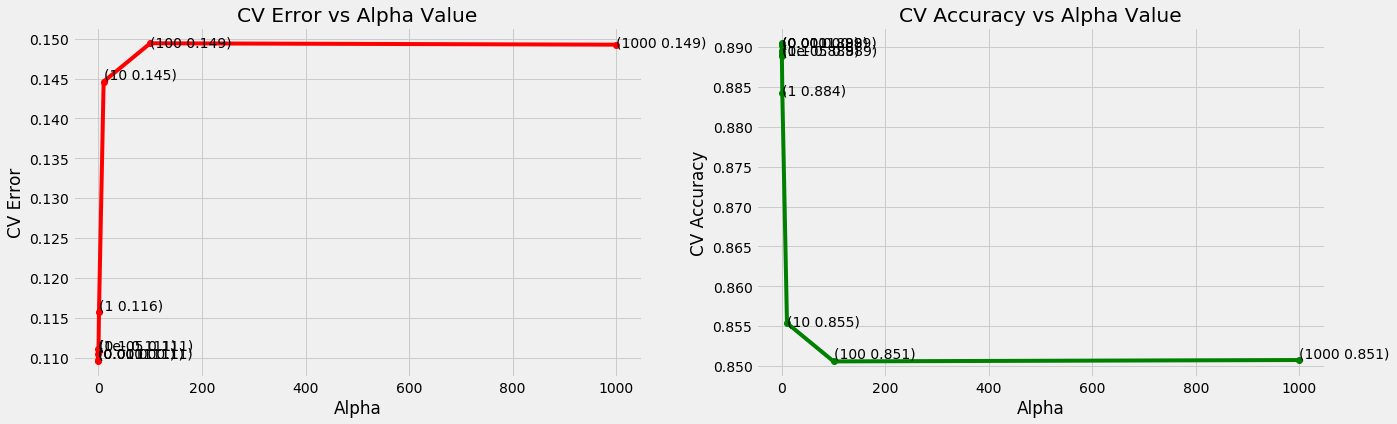


CV Error for each value of alpha:  [0.111 0.11  0.11  0.11  0.111 0.116 0.145 0.149 0.149]

CV Accuracy for each value of alpha:  [0.889 0.89  0.89  0.89  0.889 0.884 0.855 0.851 0.851]
CPU times: user 3min 2s, sys: 1.86 s, total: 3min 3s
Wall time: 3min 3s


In [28]:
%%time
if __name__ == "__main__":
    BernoulliNB_Train(X_train_binarytfidfuni, y_train)

------------Top 25 Negative Words with high Importance------------
Coeficient Factor            Features
       -16.890669  aaaaaaarrrrrggghhh
       -16.890669  aaaaaahhhhhyaaaaaa
       -16.890669              aachen
       -16.890669              aarrgh
       -16.890669                aauc
       -16.890669              abalon
       -16.890669           abbazabba
       -16.890669               abiet
       -16.890669        abolitionist
       -16.890669               abort
       -16.890669              abottl
       -16.890669              abrevi
       -16.890669           abrotanum
       -16.890669          absolutelt
       -16.890669             absoprt
       -16.890669              absurt
       -16.890669              abswer
       -16.890669             abvious
       -16.890669             accepet
       -16.890669            acceptal
       -16.890669          acceptalbl
       -16.890669               accor
       -16.890669            accordng
       -16.890669    

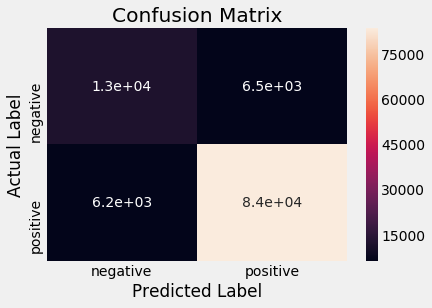

[[12567  6480]
 [ 6226 83807]]

Test Error : 0.116
Test Accuracy : 88.352 %
True Negative : 12567
False Positive : 6480
False Negative : 6226
True Positive : 83807
Precission Score : 0.798
Recall Score : 0.795
F1 Score : 0.797
CPU times: user 8.12 s, sys: 12 ms, total: 8.13 s
Wall time: 7.86 s


In [29]:
%%time
if __name__ == "__main__":
    BernoulliNB_Test(X_train_binarytfidfuni, X_test_binarytfidfuni, y_train, y_test, 0.01, binarytfidf_unigram)

### Using Multinomial Naive Bayes :


Optimal alpha:  {'alpha': 0.01}

CrossValidation Error: 0.117

CrossValidation Accuracy: 88.26 %




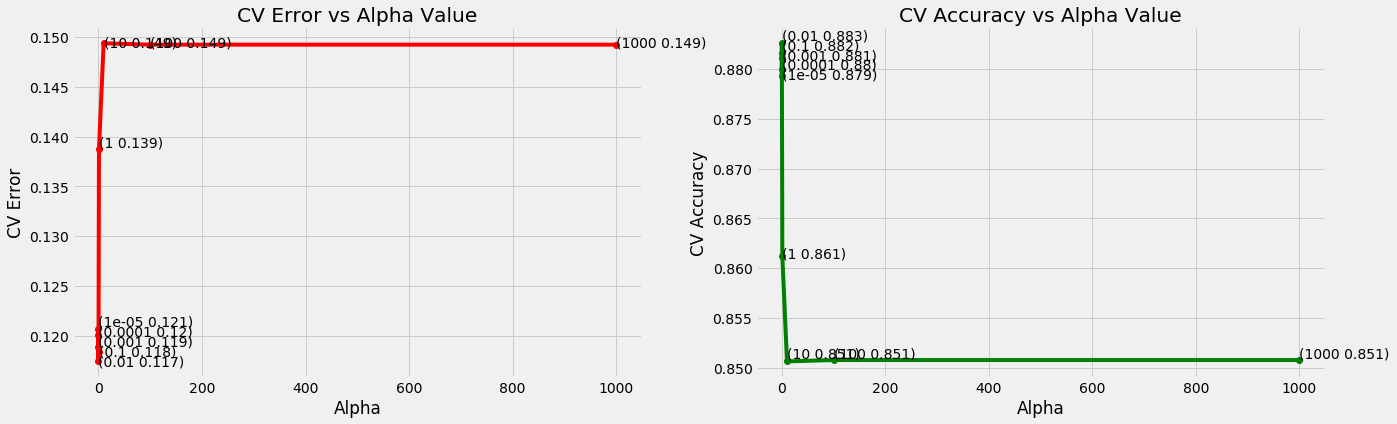


CV Error for each value of alpha:  [0.121 0.12  0.119 0.117 0.118 0.139 0.149 0.149 0.149]

CV Accuracy for each value of alpha:  [0.879 0.88  0.881 0.883 0.882 0.861 0.851 0.851 0.851]
CPU times: user 2min 56s, sys: 1.32 s, total: 2min 58s
Wall time: 2min 58s


In [66]:
%%time
if __name__ == "__main__":
    MultinomialNB_Train(X_train_tfidfuni, y_train)

------------Top 25 Negative Words with high Importance------------
Coeficient Factor            Features
       -18.434172  aaaaaaarrrrrggghhh
       -18.434172  aaaaaahhhhhyaaaaaa
       -18.434172              aachen
       -18.434172              aarrgh
       -18.434172                aauc
       -18.434172              abalon
       -18.434172           abbazabba
       -18.434172               abiet
       -18.434172        abolitionist
       -18.434172               abort
       -18.434172              abottl
       -18.434172              abrevi
       -18.434172           abrotanum
       -18.434172          absolutelt
       -18.434172             absoprt
       -18.434172              absurt
       -18.434172              abswer
       -18.434172             abvious
       -18.434172             accepet
       -18.434172            acceptal
       -18.434172          acceptalbl
       -18.434172               accor
       -18.434172            accordng
       -18.434172    

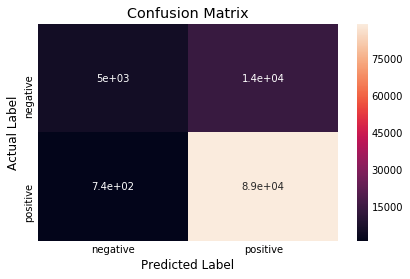

[[ 4952 14095]
 [  745 89288]]

Test Error : 0.136
Test Accuracy : 86.395 %
True Negative : 4952
False Positive : 14095
False Negative : 745
True Positive : 89288
Precission Score : 0.866
Recall Score : 0.626
F1 Score : 0.662
CPU times: user 8.11 s, sys: 20 ms, total: 8.13 s
Wall time: 7.87 s


In [94]:
%%time
if __name__ == "__main__":
    MultinomialNB_Test(X_train_tfidfuni, X_test_tfidfuni, y_train, y_test, 0.01, tfidf_unigram)

### [8.4] TF-IDF(bigram) : <a name="tfidfbi"></a>

<b>Count Based TF-IDF :</b>

In [50]:
%%time
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidfbi = tfidf_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_tfidfbi))
print("The shape of text TFIDF vectorizer: ", X_train_tfidfbi.get_shape())
print("Number of unique word: ", X_train_tfidfbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (254519, 2295006)
Number of unique word:  2295006
CPU times: user 39.2 s, sys: 348 ms, total: 39.6 s
Wall time: 39.6 s


In [51]:
%%time
X_test_tfidfbi = tfidf_bigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_tfidfbi.get_shape())
print("Number of unique word: ", X_test_tfidfbi.get_shape()[1])

The shape of text TFIDF vectorizer:  (109080, 2295006)
Number of unique word:  2295006
CPU times: user 12.7 s, sys: 32 ms, total: 12.7 s
Wall time: 12.7 s


In [52]:
dumpfile(X_train_tfidfbi,"X_train_tfidfbi")
dumpfile(X_test_tfidfbi,"X_test_tfidfbi")

In [95]:
X_train_tfidfbi = loadfile("X_train_tfidfbi")
X_test_tfidfbi = loadfile("X_test_tfidfbi")

In [56]:
print("Shape of Training Data: ",X_train_tfidfbi.shape)
print("Shape of Test Data: ",X_test_tfidfbi.shape)

Shape of Training Data:  (254519, 2295006)
Shape of Test Data:  (109080, 2295006)


<b>Binary TF-IDF :</b>

In [30]:
%%time
binarytfidf_bigram = TfidfVectorizer(ngram_range=(1, 2), binary = True)
X_train_binarytfidfbi = binarytfidf_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_binarytfidfbi))
print("The shape of text TFIDF vectorizer: ", X_train_binarytfidfbi.get_shape())
print("Number of unique word: ", X_train_binarytfidfbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (254519, 2295006)
Number of unique word:  2295006
CPU times: user 39.9 s, sys: 452 ms, total: 40.3 s
Wall time: 40.3 s


In [31]:
%%time
X_test_binarytfidfbi = binarytfidf_bigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_binarytfidfbi.get_shape())
print("Number of unique word: ", X_test_binarytfidfbi.get_shape()[1])

The shape of text TFIDF vectorizer:  (109080, 2295006)
Number of unique word:  2295006
CPU times: user 12.9 s, sys: 48 ms, total: 13 s
Wall time: 13 s


In [32]:
print("Shape of Training Data: ",X_train_binarytfidfbi.shape)
print("Shape of Test Data: ",X_test_binarytfidfbi.shape)

Shape of Training Data:  (254519, 2295006)
Shape of Test Data:  (109080, 2295006)


### Using Bernoulli Naive Bayes(binary features) :


Optimal alpha:  {'alpha': 0.001}

CrossValidation Error: 0.094

CrossValidation Accuracy: 90.626 %




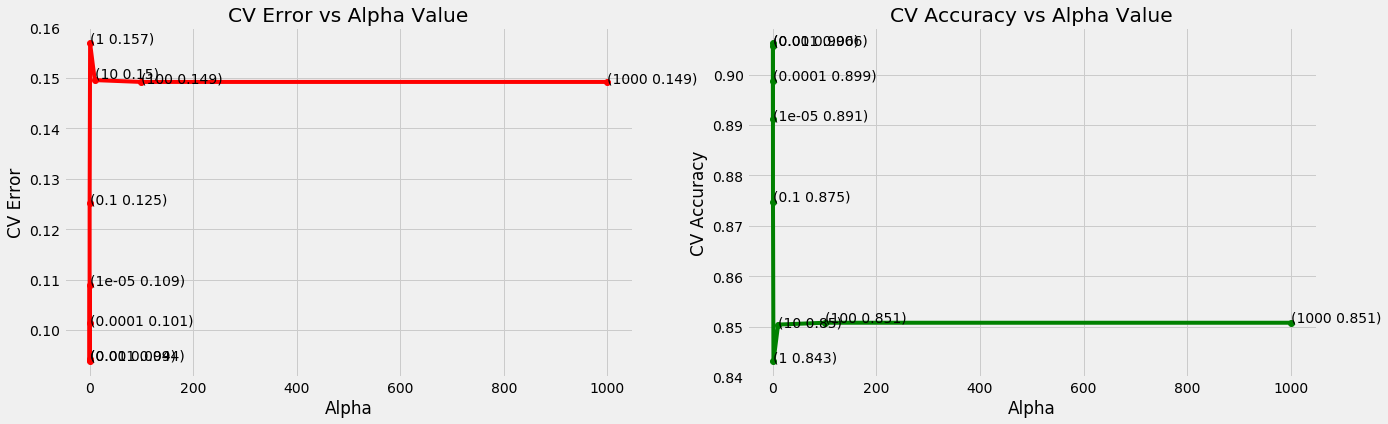


CV Error for each value of alpha:  [0.109 0.101 0.094 0.094 0.125 0.157 0.15  0.149 0.149]

CV Accuracy for each value of alpha:  [0.891 0.899 0.906 0.906 0.875 0.843 0.85  0.851 0.851]
CPU times: user 4min 45s, sys: 10 s, total: 4min 55s
Wall time: 4min 55s


In [33]:
%%time
if __name__ == "__main__":
    BernoulliNB_Train(X_train_binarytfidfbi, y_train)

------------Top 25 Negative Words with high Importance------------
Coeficient Factor                 Features
       -19.193254                 aaa dont
       -19.193254       aaaaaaarrrrrggghhh
       -19.193254  aaaaaaarrrrrggghhh back
       -19.193254       aaaaaahhhhhyaaaaaa
       -19.193254  aaaaaahhhhhyaaaaaa fire
       -19.193254                   aachen
       -19.193254            aachen munich
       -19.193254           aachen printen
       -19.193254            aafco certifi
       -19.193254            aafco definit
       -19.193254              aafco regul
       -19.193254             aamzon howev
       -19.193254                   aarrgh
       -19.193254             aarrgh final
       -19.193254                     aauc
       -19.193254               aauc shelv
       -19.193254             aback flavor
       -19.193254            aback foreign
       -19.193254               aback main
       -19.193254             aback potenc
       -19.193254            a

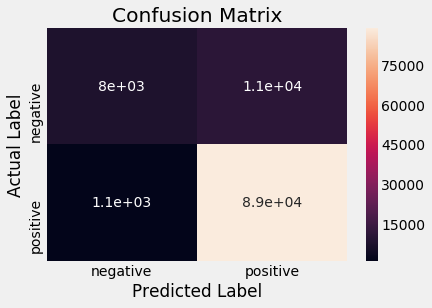

[[ 7957 11090]
 [ 1077 88956]]

Test Error : 0.112
Test Accuracy : 88.846 %
True Negative : 7957
False Positive : 11090
False Negative : 1077
True Positive : 88956
Precission Score : 0.885
Recall Score : 0.703
F1 Score : 0.751
CPU times: user 21 s, sys: 100 ms, total: 21.1 s
Wall time: 20.8 s


In [34]:
%%time
if __name__ == "__main__":
    BernoulliNB_Test(X_train_binarytfidfbi, X_test_binarytfidfbi, y_train, y_test, 0.001, binarytfidf_bigram)

### Using Multinomial Naive Bayes :


Optimal alpha:  {'alpha': 0.001}

CrossValidation Error: 0.097

CrossValidation Accuracy: 90.265 %




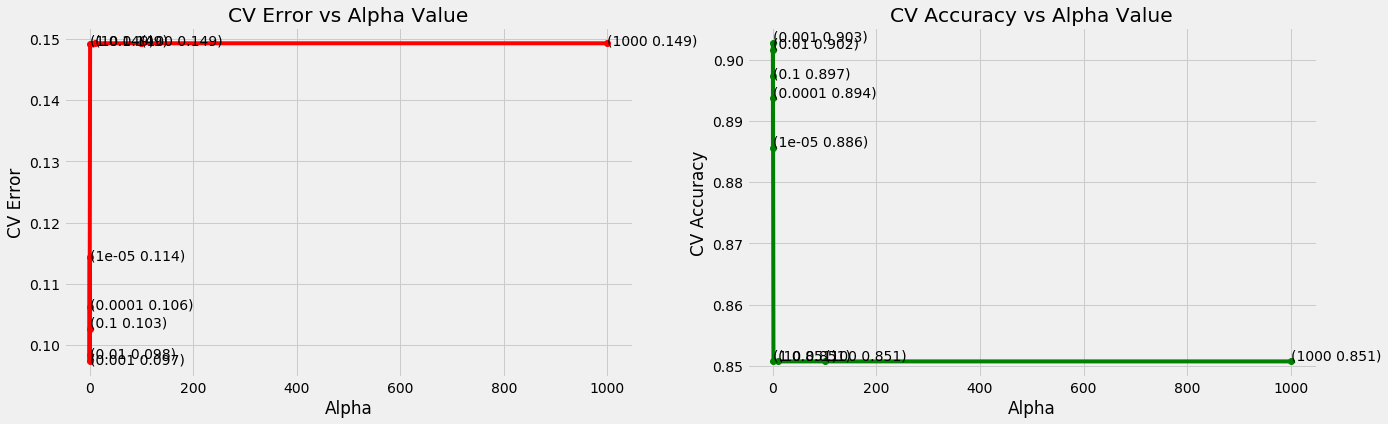


CV Error for each value of alpha:  [0.114 0.106 0.097 0.098 0.103 0.149 0.149 0.149 0.149]

CV Accuracy for each value of alpha:  [0.886 0.894 0.903 0.902 0.897 0.851 0.851 0.851 0.851]
CPU times: user 4min 8s, sys: 6.21 s, total: 4min 14s
Wall time: 4min 14s


In [68]:
%%time
if __name__ == "__main__":
    MultinomialNB_Train(X_train_tfidfbi, y_train)

------------Top 25 Negative Words with high Importance------------
Coeficient Factor                 Features
       -21.140633                 aaa dont
       -21.140633       aaaaaaarrrrrggghhh
       -21.140633  aaaaaaarrrrrggghhh back
       -21.140633       aaaaaahhhhhyaaaaaa
       -21.140633  aaaaaahhhhhyaaaaaa fire
       -21.140633                   aachen
       -21.140633            aachen munich
       -21.140633           aachen printen
       -21.140633            aafco certifi
       -21.140633            aafco definit
       -21.140633              aafco regul
       -21.140633             aamzon howev
       -21.140633                   aarrgh
       -21.140633             aarrgh final
       -21.140633                     aauc
       -21.140633               aauc shelv
       -21.140633             aback flavor
       -21.140633            aback foreign
       -21.140633               aback main
       -21.140633             aback potenc
       -21.140633            a

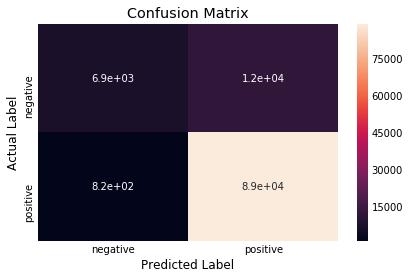

[[ 6870 12177]
 [  821 89212]]

Test Error : 0.119
Test Accuracy : 88.084 %
True Negative : 6870
False Positive : 12177
False Negative : 821
True Positive : 89212
Precission Score : 0.887
Recall Score : 0.676
F1 Score : 0.723
CPU times: user 29.6 s, sys: 100 ms, total: 29.7 s
Wall time: 29.4 s


In [97]:
%%time
if __name__ == "__main__":
    MultinomialNB_Test(X_train_tfidfbi, X_test_tfidfbi, y_train, y_test, 0.001, tfidf_bigram)

## [9] Conclusion : <a name="conclusion"></a>


| Featurization Model | Bernoulli NB |  |  |  | Multinomial Naive Bayes |  |  |  |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|  | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> |
| <b>BOW(unigram)</b> | 88.352 % | 0.798  | 0.795 | 0.797 | 89.826 % | 0.824  | 0.821 | 0.822 |
| <b>BOW(bigram)</b> | 88.846 % | 0.885  | 0.703 | 0.751 | 88.799 % | 0.909  | 0.69 | 0.741 |
| <b>TF-IDF(unigram)</b> | 88.352 % | 0.798  | 0.795 | 0.797 | 86.395 % | 0.866  | 0.626 | 0.661 |
| <b>TF-IDF(bigram)</b> | 88.846 % | 0.885  | 0.703 | 0.751 | 88.084 % | 0.887  | 0.676 | 0.723 |

<br>
<b>1 - </b>Using <b>Bag Of Words(unigram)</b> method, <b>Multinomial Naive Bayes</b> model gives best accuracy of <b>89.826 %</b> and F1 score of <b>0.822</b> with <b>alpha = 1</b>.

<b>2- </b>Both MultinomialNB and BernouliNB are suitable for discrete data. Multinomial NB works with occurence count of words while later is suitable for binary/boolean features.

<b>3 - </b>It is also observed that Run Time complexity of Naive Bayes is <b>super fast</b> as compared to KNN. Thus, Naive Bayes can be used as a classification model for <b>low latency applications</b>.

<b>4 - </b>Naive Bayes holds a concept of <b>"conditional independence"</b> that states features should be independent of each other. Hence featurization techniques like <b>average word2vec and tfidf weighted word2vec</b> which involves dependency between features <b>doesnot perform good</b> with Naive Bayes.